In [27]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

from PIL import Image
import pandas as pd

from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

import torchvision.models as models

import torch.nn as nn
import torch.nn.functional as F

from torchvision.utils import make_grid
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.model_selection import StratifiedShuffleSplit

In [28]:
def split_train_for_val(train_df):
    #take 15% of the train data for validation set
    #do a random split
    x = train_df.iloc[:, 1:]
    y = train_df.iloc[:, 0]
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
    for train_idx, val_idx in split.split(x, y):
        x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    x_val.insert(loc=0, value = y_val, column='label')
    x_train.insert(loc=0, value = y_train, column='label')

    return x_train, x_val

In [29]:
data_path = "./dataset/archive/"
# dataset from https://www.kaggle.com/datasets/datamunge/sign-language-mnist/

test_df = pd.read_csv(data_path+'sign_mnist_test/sign_mnist_test.csv')
train_df = pd.read_csv(data_path+'sign_mnist_train/sign_mnist_train.csv')

train_df, val_df = split_train_for_val(train_df)

In [30]:
def dataset_to_tensor(test, train, val):
    train_images = train.iloc[:, 1:].to_numpy(dtype = 'float32')
    test_images = test.iloc[:, 1:].to_numpy(dtype = 'float32')
    val_images = val.iloc[:, 1:].to_numpy(dtype = 'float32')
    train_labels = train['label'].values
    test_labels = test['label'].values
    val_labels = val['label'].values

    train_ds = torch.from_numpy(train_images.reshape(train_images.shape[0],1,28,28))
    train_label_ds = torch.from_numpy(train_labels)

    test_ds = torch.from_numpy(test_images.reshape(test_images.shape[0],1,28,28))
    test_label_ds = torch.from_numpy(test_labels)

    val_ds = torch.from_numpy(val_images.reshape(val_images.shape[0],1,28,28))
    val_label_ds = torch.from_numpy(val_labels)

    train_ds = TensorDataset(train_ds, train_label_ds)
    test_ds = TensorDataset(test_ds, test_label_ds)
    val_ds = TensorDataset(val_ds, val_label_ds)
    return train_ds, test_ds, val_ds

In [31]:
train_ds, test_ds, val_ds = dataset_to_tensor(test_df, train_df, val_df)

In [34]:
data_transforms = transforms.Compose([
    transforms.RandomRotation(15),  # Rotate within [-15, 15] degrees
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomResizedCrop(28, scale=(0.85, 1.15)),  # For 28x28 input size
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

batch_size = 32
shuffle = True
num_workers = 4  # Number of CPU processes for data loading

In [35]:
train_ds.transform = data_transforms
train_loader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
test_loader = DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_loader = DataLoader(dataset=val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

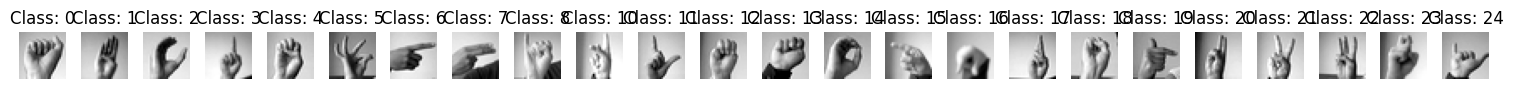

In [43]:
num_classes = 26
sampled_images = {i: None for i in range(num_classes)}

# Iterate over the dataloader until an image from each class is sampled
for images, labels in train_loader:
    for img, label in zip(images, labels):
        if sampled_images[label.item()] is None:
            sampled_images[label.item()] = img
        if all(val is not None for val in sampled_images.values()):
            break

# Plot the sampled images
sampled_images = {k: v for k, v in sampled_images.items() if v is not None}
fig, axes = plt.subplots(1, num_classes-2, figsize=(15, 3)) # -2 since we dont have two classes that require motion

for ax, (class_idx, img) in zip(axes, sampled_images.items()):
    # Depending on your data normalization and image shape, you might need to adjust the following line
    ax.imshow(img.squeeze().numpy(), cmap='gray')  # assuming grayscale images
    ax.set_title(f'Class: {class_idx}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:

def evaluate_on_test(model, test_loader, criterion, device):
    """
    Evaluate a PyTorch model on a test dataset.

    Parameters:
    - model (torch.nn.Module): The model to be evaluated.
    - test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
    - criterion (torch.nn.Module): The loss function.
    - device (torch.device): Device ("cuda" or "cpu").

    Returns:
    - test_loss (float): The evaluation loss on the test set.
    - test_accuracy (float): The evaluation accuracy on the test set.
    """
    
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # No need to compute gradients during evaluation
        for inputs, labels in test_loader:
            # inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            
            # Calculate the number of correct predictions
            _, predicted = outputs.max(1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    avg_test_loss = total_loss / total_samples
    test_accuracy = correct_predictions / total_samples

    return avg_test_loss, test_accuracy


def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader):
    history = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.1)
    scheduler = ReduceLROnPlateau(optimizer, 'min')
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
        scheduler.step(result['val_loss'])
    return history

In [ ]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        # Define the layers
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 29)  # 29 output classes

        # Dropout layer
        self.dropout = nn.Dropout(0.5)

        # Activation function
        self.relu = nn.ReLU()

    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def forward(self, x):
        # First convolution + pooling
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        # Second convolution + pooling
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        # x = self.dropout(x)

        # Third convolution + pooling
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)

        # Flatten the output from the convolutional layers
        x = x.view(-1, 128 * 3 * 3)

        # First fully connected layer
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Second fully connected layer (output layer)
        x = self.fc2(x)
        return x

    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))


In [37]:
model = CustomCNN()
fit(10, 0.0001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.0942, val_acc: 0.6506
Epoch [1], val_loss: 0.5041, val_acc: 0.8370
Epoch [2], val_loss: 0.3005, val_acc: 0.9161
Epoch [3], val_loss: 0.2304, val_acc: 0.9423
Epoch [4], val_loss: 0.2243, val_acc: 0.9425
Epoch [5], val_loss: 0.1978, val_acc: 0.9545
Epoch [6], val_loss: 0.1981, val_acc: 0.9541
Epoch [7], val_loss: 0.2087, val_acc: 0.9506
Epoch [8], val_loss: 0.1700, val_acc: 0.9662
Epoch [9], val_loss: 0.1725, val_acc: 0.9636


[{'val_loss': 1.0941557884216309, 'val_acc': 0.6505624055862427},
 {'val_loss': 0.5041021108627319, 'val_acc': 0.8370302319526672},
 {'val_loss': 0.30046480894088745, 'val_acc': 0.9160873889923096},
 {'val_loss': 0.23044413328170776, 'val_acc': 0.94225013256073},
 {'val_loss': 0.22426268458366394, 'val_acc': 0.9424924254417419},
 {'val_loss': 0.19784332811832428, 'val_acc': 0.9544573426246643},
 {'val_loss': 0.19809091091156006, 'val_acc': 0.9541203379631042},
 {'val_loss': 0.20866817235946655, 'val_acc': 0.9505813717842102},
 {'val_loss': 0.1700403094291687, 'val_acc': 0.9662327170372009},
 {'val_loss': 0.17245550453662872, 'val_acc': 0.9635679721832275}]

In [39]:
criterion = torch.nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_loss, test_acc = evaluate_on_test(model, test_loader, criterion, device)
print(test_loss, test_acc)

0.18815268226262916 0.949665365309537


In [41]:
# Save
torch.save(model, 'trained_model.pth')